# Wheelchair Rugby Player Valuation & Lineup Optimization

## Part 0: Setup and Data Loading

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Gurobi for optimization
import gurobipy as gp
from gurobipy import GRB

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Load data
player_data = pd.read_csv('data/player_data.csv')
stint_data = pd.read_csv('data/stint_data.csv')

# Create lookup dictionary for mobility ratings
mobility_ratings = dict(zip(player_data['player'], player_data['rating']))

print(f"Loaded {len(player_data)} players")
print(f"Loaded {len(stint_data)} stints")
print(f"{stint_data['game_id'].nunique()} unique games")

Loaded 144 players
Loaded 7448 stints
660 unique games


## Part 1: Data Overview

In [70]:
# Teams in dataset
all_teams = sorted(set(stint_data['h_team'].unique()) | set(stint_data['a_team'].unique()))
print(f"Teams ({len(all_teams)}): {all_teams}")

# Players per team
player_data['team'] = player_data['player'].str.rsplit('_', n=1).str[0]
print(f"\nPlayers per team: {player_data.groupby('team').size().to_dict()}")

# Mobility rating distribution
print(f"\nMobility rating stats:")
print(f"  Min: {player_data['rating'].min()}, Max: {player_data['rating'].max()}")
print(f"  Mean: {player_data['rating'].mean():.2f}")

Teams (12): ['Argentina', 'Brazil', 'Canada', 'Chile', 'Columbia', 'Denmark', 'France', 'Great.Britain', 'Japan', 'Poland', 'Sweden', 'USA']

Players per team: {'Argentina': 12, 'Brazil': 12, 'Canada': 12, 'Chile': 12, 'Columbia': 12, 'Denmark': 12, 'France': 12, 'Great.Britain': 12, 'Japan': 12, 'Poland': 12, 'Sweden': 12, 'USA': 12}

Mobility rating stats:
  Min: 0.0, Max: 3.5
  Mean: 1.98


## Part 1B: Parameter Justification Analysis

In [71]:
# ============================================================
# ANALYSIS 1: GAME STATE & GOAL DIFFERENTIAL ANALYSIS
# ============================================================

game_results = stint_data.groupby(['game_id', 'h_team', 'a_team']).agg({
    'h_goals': 'sum', 
    'a_goals': 'sum', 
    'minutes': 'sum'
}).reset_index()

game_results['goal_diff'] = game_results['h_goals'] - game_results['a_goals']
game_results['total_goals'] = game_results['h_goals'] + game_results['a_goals']
game_results['winner'] = game_results.apply(
    lambda x: x['h_team'] if x['h_goals'] > x['a_goals'] else 
              (x['a_team'] if x['a_goals'] > x['h_goals'] else 'Tie'), axis=1
)

print("="*60)
print("GAME-LEVEL STATISTICS")
print("="*60)
print(f"Total games: {len(game_results)}")
print(f"\nGoal Differential (absolute value):")
print(f"  Mean: {game_results['goal_diff'].abs().mean():.1f}")
print(f"  Median: {game_results['goal_diff'].abs().median():.1f}")
print(f"  Std Dev: {game_results['goal_diff'].abs().std():.1f}")
print(f"  Min: {game_results['goal_diff'].abs().min()}")
print(f"  Max: {game_results['goal_diff'].abs().max()}")

print(f"\nTotal Goals per Game:")
print(f"  Mean: {game_results['total_goals'].mean():.1f}")
print(f"  Min: {game_results['total_goals'].min()}")
print(f"  Max: {game_results['total_goals'].max()}")

GAME-LEVEL STATISTICS
Total games: 660

Goal Differential (absolute value):
  Mean: 14.7
  Median: 12.0
  Std Dev: 11.2
  Min: 1
  Max: 77

Total Goals per Game:
  Mean: 99.6
  Min: 65
  Max: 168


In [72]:
# Team standings from game results
game_results = stint_data.groupby(['game_id', 'h_team', 'a_team']).agg({
    'h_goals': 'sum', 'a_goals': 'sum', 'minutes': 'sum'
}).reset_index()

game_results['winner'] = game_results.apply(
    lambda x: x['h_team'] if x['h_goals'] > x['a_goals'] else x['a_team'], axis=1
)

# Calculate team records
team_wins = pd.concat([
    game_results[game_results['h_goals'] > game_results['a_goals']]['h_team'],
    game_results[game_results['a_goals'] > game_results['h_goals']]['a_team']
]).value_counts().rename('wins')

team_losses = pd.concat([
    game_results[game_results['h_goals'] < game_results['a_goals']]['h_team'],
    game_results[game_results['a_goals'] < game_results['h_goals']]['a_team']
]).value_counts().rename('losses')

team_standings = pd.DataFrame({'wins': team_wins, 'losses': team_losses}).fillna(0).astype(int)
team_standings['win_pct'] = (team_standings['wins'] / (team_standings['wins'] + team_standings['losses']) * 100).round(1)
team_standings = team_standings.sort_values('wins', ascending=False)

print("Team Standings:")
print(team_standings)

Team Standings:
               wins  losses  win_pct
Japan            91      19     82.7
USA              79      31     71.8
France           70      40     63.6
Canada           66      44     60.0
Great.Britain    66      44     60.0
Poland           65      45     59.1
Brazil           63      47     57.3
Denmark          57      53     51.8
Columbia         55      55     50.0
Chile            23      87     20.9
Argentina        13      97     11.8
Sweden           12      98     10.9


In [73]:
# ============================================================
# ANALYSIS 2: PLAYER STINT PARTICIPATION ANALYSIS
# ============================================================
# Goal: Understand how many stints each player participated in
# This motivates the need for Bayesian priors to stabilize estimates

player_columns = ['home1', 'home2', 'home3', 'home4', 'away1', 'away2', 'away3', 'away4']

# Flatten all player appearances
all_appearances = []
for col in player_columns:
    all_appearances.extend(stint_data[col].tolist())

# Count appearances per player
from collections import Counter
stint_counts = Counter(all_appearances)
stint_counts_df = pd.DataFrame([
    {'player': player, 'stint_count': count} 
    for player, count in stint_counts.items()
]).sort_values('stint_count', ascending=False)

# Add team info
stint_counts_df['team'] = stint_counts_df['player'].str.rsplit('_', n=1).str[0]

print("="*60)
print("PLAYER STINT PARTICIPATION ANALYSIS")
print("="*60)
print(f"\nStint Count Statistics (per player):")
print(f"  Mean: {stint_counts_df['stint_count'].mean():.1f}")
print(f"  Median: {stint_counts_df['stint_count'].median():.1f}")
print(f"  Std Dev: {stint_counts_df['stint_count'].std():.1f}")
print(f"  Min: {stint_counts_df['stint_count'].min()}")
print(f"  Max: {stint_counts_df['stint_count'].max()}")
print(f"  Coefficient of Variation: {stint_counts_df['stint_count'].std() / stint_counts_df['stint_count'].mean() * 100:.1f}%")

# Show distribution buckets
print(f"\nStint Count Distribution:")
bins = [0, 100, 200, 300, 400, 500, 600, 1000]
labels = ['0-100', '101-200', '201-300', '301-400', '401-500', '501-600', '600+']
stint_counts_df['bucket'] = pd.cut(stint_counts_df['stint_count'], bins=bins, labels=labels)
print(stint_counts_df['bucket'].value_counts().sort_index())

# Show top 5 and bottom 5 players
print(f"\nTop 5 Players by Stint Count:")
print(stint_counts_df.head(5)[['player', 'team', 'stint_count']].to_string(index=False))

print(f"\nBottom 5 Players by Stint Count:")
print(stint_counts_df.tail(5)[['player', 'team', 'stint_count']].to_string(index=False))

PLAYER STINT PARTICIPATION ANALYSIS

Stint Count Statistics (per player):
  Mean: 413.8
  Median: 423.0
  Std Dev: 96.3
  Min: 187
  Max: 916
  Coefficient of Variation: 23.3%

Stint Count Distribution:
bucket
0-100       0
101-200     3
201-300    10
301-400    41
401-500    74
501-600    15
600+        1
Name: count, dtype: int64

Top 5 Players by Stint Count:
           player          team  stint_count
        Sweden_p5        Sweden          916
         Chile_p6         Chile          575
Great.Britain_p12 Great.Britain          566
         Japan_p4         Japan          561
         Chile_p2         Chile          553

Bottom 5 Players by Stint Count:
      player      team  stint_count
   Chile_p10     Chile          208
Argentina_p5 Argentina          206
   Sweden_p4    Sweden          194
    Chile_p9     Chile          188
   Sweden_p9    Sweden          187


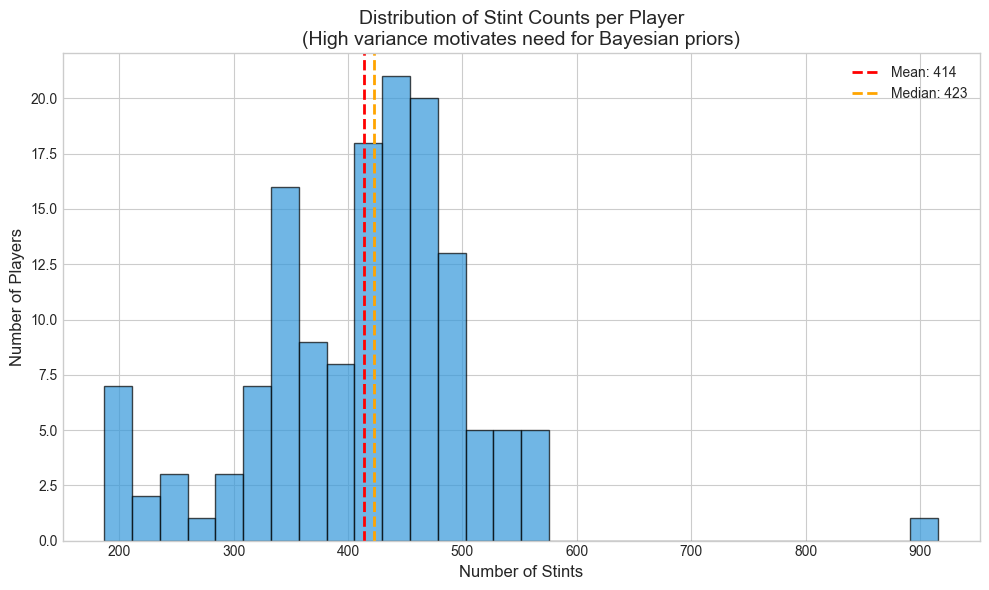

In [74]:
# Visualize stint count distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(stint_counts_df['stint_count'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
ax.axvline(stint_counts_df['stint_count'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {stint_counts_df['stint_count'].mean():.0f}")
ax.axvline(stint_counts_df['stint_count'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {stint_counts_df['stint_count'].median():.0f}")

ax.set_xlabel('Number of Stints', fontsize=12)
ax.set_ylabel('Number of Players', fontsize=12)
ax.set_title('Distribution of Stint Counts per Player\n(High variance motivates need for Bayesian priors)', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

In [75]:
# ============================================================
# ANALYSIS 3: PRIOR WEIGHT SENSITIVITY ANALYSIS
# ============================================================
# Goal: Test different prior weights and see how player rankings change

def quick_rapm(stint_data, player_data, alpha=10.0):
    """Quick RAPM calculation for sensitivity analysis"""
    all_players = player_data['player'].tolist()
    player_to_idx = {p: i for i, p in enumerate(all_players)}
    n_players = len(all_players)
    
    X_rows, y_offense, weights = [], [], []
    
    for _, stint in stint_data.iterrows():
        minutes = max(stint['minutes'], 0.1)
        
        # Home perspective
        home_x = np.zeros(n_players)
        for col in ['home1', 'home2', 'home3', 'home4']:
            if stint[col] in player_to_idx:
                home_x[player_to_idx[stint[col]]] = 1
        X_rows.append(home_x)
        y_offense.append(stint['h_goals'] / minutes)
        weights.append(minutes)
        
        # Away perspective
        away_x = np.zeros(n_players)
        for col in ['away1', 'away2', 'away3', 'away4']:
            if stint[col] in player_to_idx:
                away_x[player_to_idx[stint[col]]] = 1
        X_rows.append(away_x)
        y_offense.append(stint['a_goals'] / minutes)
        weights.append(minutes)
    
    X = np.array(X_rows)
    y = np.array(y_offense)
    w = np.array(weights)
    
    model = Ridge(alpha=alpha)
    model.fit(X, y, sample_weight=w)
    
    return pd.DataFrame({
        'player': all_players,
        'RAPM_data': model.coef_,
        'mobility': [mobility_ratings.get(p, 2.0) for p in all_players]
    })

# Get data-only RAPM
rapm_base = quick_rapm(stint_data, player_data, alpha=10.0)

# Normalize RAPM to 0-1 scale
rapm_min, rapm_max = rapm_base['RAPM_data'].min(), rapm_base['RAPM_data'].max()
rapm_base['RAPM_norm'] = (rapm_base['RAPM_data'] - rapm_min) / (rapm_max - rapm_min + 1e-6)

# Create mobility-based prior (higher mobility = higher offensive expectation)
rapm_base['mobility_prior'] = rapm_base['mobility'] / 3.5

# Test different prior weights
prior_weights_to_test = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]

print("="*60)
print("PRIOR WEIGHT SENSITIVITY ANALYSIS")
print("="*60)
print("\nHow do top 5 players change with different prior weights?")
print("(0.0 = pure data, 1.0 = pure mobility prior)\n")

for pw in prior_weights_to_test:
    rapm_base[f'posterior_{pw}'] = (1 - pw) * rapm_base['RAPM_norm'] + pw * rapm_base['mobility_prior']

# Show top 5 for selected weights
for pw in [0.0, 0.3, 0.5, 1.0]:
    top5 = rapm_base.nlargest(5, f'posterior_{pw}')[['player', 'mobility', f'posterior_{pw}']]
    print(f"\n--- Prior Weight = {pw} ---")
    print(top5.to_string(index=False))

PRIOR WEIGHT SENSITIVITY ANALYSIS

How do top 5 players change with different prior weights?
(0.0 = pure data, 1.0 = pure mobility prior)


--- Prior Weight = 0.0 ---
          player  mobility  posterior_0.0
      Denmark_p8       3.5       0.999999
       Japan_p12       2.5       0.921540
Great.Britain_p2       3.5       0.916770
       Canada_p9       2.5       0.845849
       Brazil_p1       2.0       0.828593

--- Prior Weight = 0.3 ---
          player  mobility  posterior_0.3
      Denmark_p8       3.5       0.999999
Great.Britain_p2       3.5       0.941739
       Sweden_p9       3.5       0.871871
       Japan_p12       2.5       0.859363
       Sweden_p4       3.5       0.851726

--- Prior Weight = 0.5 ---
          player  mobility  posterior_0.5
      Denmark_p8       3.5       0.999999
Great.Britain_p2       3.5       0.958385
       Sweden_p9       3.5       0.908479
       Sweden_p4       3.5       0.894090
      France_p11       3.5       0.892858

--- Prior Weight = 1

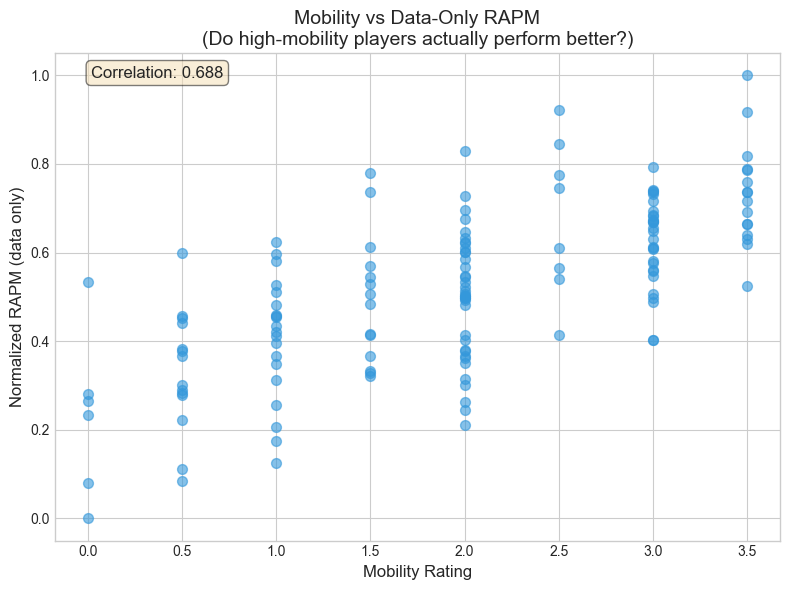

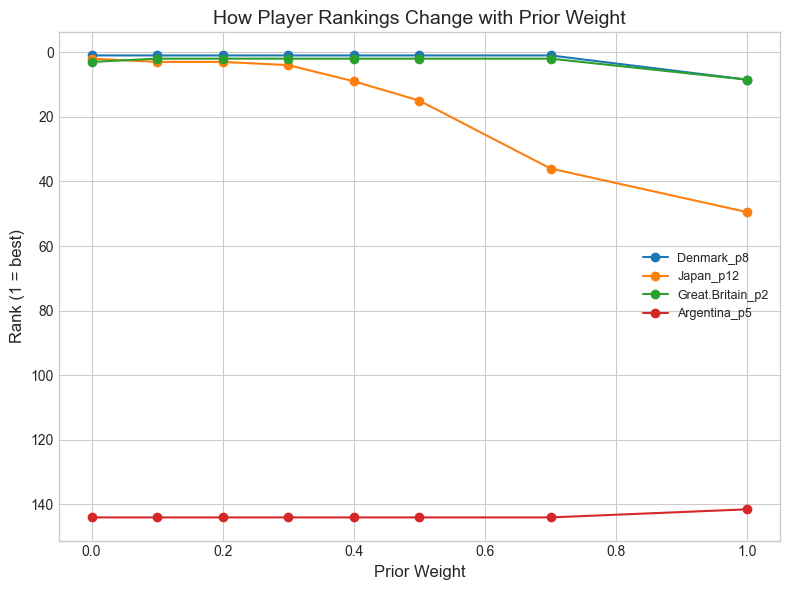

In [76]:
# ============================================================
# FIGURE 1: Mobility vs RAPM Correlation
# ============================================================
fig1, ax1 = plt.subplots(figsize=(8, 6))

ax1.scatter(rapm_base['mobility'], rapm_base['RAPM_norm'], alpha=0.6, s=50, c='#3498db')
ax1.set_xlabel('Mobility Rating', fontsize=12)
ax1.set_ylabel('Normalized RAPM (data only)', fontsize=12)
ax1.set_title('Mobility vs Data-Only RAPM\n(Do high-mobility players actually perform better?)', fontsize=14)

# Add correlation
corr = rapm_base['mobility'].corr(rapm_base['RAPM_norm'])
ax1.annotate(f'Correlation: {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# ============================================================
# FIGURE 2: Prior Weight Sensitivity Analysis
# ============================================================
fig2, ax2 = plt.subplots(figsize=(8, 6))

# Track rank of a few specific players
sample_players = rapm_base.nlargest(3, 'RAPM_norm')['player'].tolist()[:3]
sample_players += rapm_base.nsmallest(3, 'RAPM_norm')['player'].tolist()[:3]

for player in sample_players[:4]:
    ranks = []
    for pw in prior_weights_to_test:
        rapm_base['temp_rank'] = rapm_base[f'posterior_{pw}'].rank(ascending=False)
        ranks.append(rapm_base[rapm_base['player'] == player]['temp_rank'].values[0])
    ax2.plot(prior_weights_to_test, ranks, marker='o', label=player)

ax2.set_xlabel('Prior Weight', fontsize=12)
ax2.set_ylabel('Rank (1 = best)', fontsize=12)
ax2.set_title('How Player Rankings Change with Prior Weight', fontsize=14)
ax2.legend(loc='best', fontsize=9)
ax2.invert_yaxis()  # Lower rank number = better

plt.tight_layout()
plt.show()


## Part 2: Individual Player Value Estimation (RAPM)

In [77]:
def build_rapm_matrices(stint_data, player_data):
    """
    Build the design matrix X and target vectors y for RAPM regression.
    
    Returns:
    - X: (n_observations, n_players) binary matrix
    - y_off: goals scored per minute (for offensive rating)
    - y_def: goals allowed per minute (for defensive rating)
    - weights: stint duration in minutes
    - players: list of player names
    """
    all_players = player_data['player'].tolist()
    player_to_idx = {p: i for i, p in enumerate(all_players)}
    n_players = len(all_players)
    
    X_rows = []
    y_offense = []
    y_defense = []
    weights = []
    
    for _, stint in stint_data.iterrows():
        minutes = max(stint['minutes'], 0.1)  # Avoid division by zero
        
        # HOME TEAM perspective
        home_x = np.zeros(n_players)
        for col in ['home1', 'home2', 'home3', 'home4']:
            player = stint[col]
            if player in player_to_idx:
                home_x[player_to_idx[player]] = 1
        
        X_rows.append(home_x)
        y_offense.append(stint['h_goals'] / minutes)  # Goals scored by home
        y_defense.append(stint['a_goals'] / minutes)  # Goals allowed by home
        weights.append(minutes)
        
        # AWAY TEAM perspective
        away_x = np.zeros(n_players)
        for col in ['away1', 'away2', 'away3', 'away4']:
            player = stint[col]
            if player in player_to_idx:
                away_x[player_to_idx[player]] = 1
        
        X_rows.append(away_x)
        y_offense.append(stint['a_goals'] / minutes)  # Goals scored by away
        y_defense.append(stint['h_goals'] / minutes)  # Goals allowed by away
        weights.append(minutes)
    
    return (
        np.array(X_rows),
        np.array(y_offense),
        np.array(y_defense),
        np.array(weights),
        all_players
    )

# Build matrices
X, y_off, y_def, weights, players = build_rapm_matrices(stint_data, player_data)
print(f"Design matrix shape: {X.shape}")
print(f"  - {X.shape[0]} observations (stints × 2 teams)")
print(f"  - {X.shape[1]} players to estimate")

Design matrix shape: (14896, 144)
  - 14896 observations (stints × 2 teams)
  - 144 players to estimate


In [78]:
def calculate_rapm(X, y_off, y_def, weights, players, alpha=10.0):
    """
    Calculate Offensive and Defensive RAPM for all players.
    
    Parameters:
    - alpha: Ridge regularization strength (higher = more shrinkage toward 0)
    
    Returns:
    - DataFrame with O_RAPM, D_RAPM, Net_RAPM for each player
    """
    # OFFENSIVE REGRESSION
    # "How does this player affect their team's SCORING rate?"
    off_model = Ridge(alpha=alpha)
    off_model.fit(X, y_off, sample_weight=weights)
    
    # DEFENSIVE REGRESSION
    # "How does this player affect goals ALLOWED?"
    def_model = Ridge(alpha=alpha)
    def_model.fit(X, y_def, sample_weight=weights)
    
    results = pd.DataFrame({
        'player': players,
        'O_RAPM': off_model.coef_,  # Higher = better offense
        'D_RAPM': def_model.coef_,  # Lower = better defense
    })
    
    # Net = Offense - Defense (high O good, low D good)
    results['Net_RAPM'] = results['O_RAPM'] - results['D_RAPM']
    
    return results

# Calculate RAPM
rapm_results = calculate_rapm(X, y_off, y_def, weights, players, alpha=10.0)

# Add metadata
rapm_results['team'] = rapm_results['player'].str.rsplit('_', n=1).str[0]
rapm_results['mobility_rating'] = rapm_results['player'].map(mobility_ratings)

print("RAPM calculation complete!")
print(f"\nTop 10 by Net RAPM:")
rapm_results.nlargest(10, 'Net_RAPM')[['player', 'mobility_rating', 'O_RAPM', 'D_RAPM', 'Net_RAPM']]

RAPM calculation complete!

Top 10 by Net RAPM:


,player,mobility_rating,O_RAPM,D_RAPM,Net_RAPM
67,Denmark_p8,3.5,0.396266,-0.319455,0.715721
25,Great.Britain_p2,3.5,0.327571,-0.352266,0.679837
23,Japan_p12,2.5,0.331507,-0.249507,0.581014
57,France_p10,3.0,0.226167,-0.338721,0.564888
84,Brazil_p1,2.0,0.254792,-0.308337,0.563129
58,France_p11,3.5,0.219401,-0.271549,0.490950
18,Japan_p7,2.0,0.170525,-0.257553,0.428079
44,Canada_p9,2.5,0.269034,-0.149506,0.418540
46,Canada_p11,2.0,0.145189,-0.236322,0.381511
7,USA_p8,2.5,0.210666,-0.166089,0.376755


---
## Part 3: Bayesian Integration with Mobility Ratings

We enhance RAPM by using **mobility ratings as prior beliefs**:
- High mobility (3.0-3.5) → Expect better offense
- Low mobility (0-1.0) → Expect better defense

The Bayesian update: `Posterior = (1-w) × Data + w × Prior`

In [79]:
def bayesian_rapm(rapm_results, prior_weight=0.3):
    """
    Combine RAPM estimates with mobility-based priors.
    
    Parameters:
    - prior_weight: 0-1, how much to weight the prior vs data
      0 = pure data, 1 = pure prior
    """
    results = rapm_results.copy()
    
    # Normalize data estimates to 0-1 scale
    o_min, o_max = results['O_RAPM'].min(), results['O_RAPM'].max()
    d_min, d_max = results['D_RAPM'].min(), results['D_RAPM'].max()
    
    results['O_data_norm'] = (results['O_RAPM'] - o_min) / (o_max - o_min + 1e-6)
    results['D_data_norm'] = (results['D_RAPM'] - d_min) / (d_max - d_min + 1e-6)
    
    # Create priors from mobility ratings
    # High mobility → high offensive prior
    results['O_prior'] = results['mobility_rating'] / 3.5
    # Low mobility → good defensive prior (inverted)
    results['D_prior'] = (3.5 - results['mobility_rating']) / 3.5
    
    # BAYESIAN UPDATE
    results['O_posterior'] = (1 - prior_weight) * results['O_data_norm'] + prior_weight * results['O_prior']
    results['D_posterior'] = (1 - prior_weight) * results['D_data_norm'] + prior_weight * results['D_prior']
    results['Net_posterior'] = results['O_posterior'] - results['D_posterior']
    
    return results

# Apply Bayesian integration
player_values = bayesian_rapm(rapm_results, prior_weight=0.3)



---
## Part 4: Fatigue Model

Players get tired as they accumulate playing time within a game. We model this as:

```
Effective Value = Base Value × (1 - fatigue_rate × minutes_played)
```

With a cap so players don't become completely useless.

In [80]:
def calculate_fatigue_penalty(minutes_played, fatigue_rate=0.03, max_penalty=0.30):
    """
    Calculate fatigue multiplier based on minutes played.
    
    Returns: float 0.7-1.0 (1.0 = fresh, 0.7 = max fatigue)
    """
    penalty = min(fatigue_rate * minutes_played, max_penalty)
    return 1.0 - penalty

def get_player_minutes_in_game(stint_data, game_id, up_to_stint_idx=None):
    """
    Get cumulative minutes played by each player in a game.
    """
    game_stints = stint_data[stint_data['game_id'] == game_id].copy()
    if up_to_stint_idx is not None:
        game_stints = game_stints.iloc[:up_to_stint_idx]
    
    player_minutes = {}
    for _, stint in game_stints.iterrows():
        mins = stint['minutes']
        for col in ['home1', 'home2', 'home3', 'home4', 'away1', 'away2', 'away3', 'away4']:
            p = stint[col]
            player_minutes[p] = player_minutes.get(p, 0) + mins
    
    return player_minutes

def get_fatigue_adjusted_values(player_values, player_minutes, fatigue_rate=0.03):
    """
    Adjust player values based on accumulated fatigue.
    """
    adjusted = player_values.copy()
    adjusted['minutes_played'] = adjusted['player'].map(lambda p: player_minutes.get(p, 0))
    adjusted['fatigue_mult'] = adjusted['minutes_played'].apply(
        lambda m: calculate_fatigue_penalty(m, fatigue_rate)
    )
    
    # Apply fatigue
    adjusted['O_fatigued'] = adjusted['O_posterior'] * adjusted['fatigue_mult']
    adjusted['D_fatigued'] = adjusted['D_posterior'] / adjusted['fatigue_mult']  
    adjusted['Net_fatigued'] = adjusted['O_fatigued'] - adjusted['D_fatigued']
    
    return adjusted

# Example: Show fatigue for Game 1 after 6 stints
example_minutes = get_player_minutes_in_game(stint_data, game_id=1, up_to_stint_idx=6)
usa_players_fatigue = {p: m for p, m in example_minutes.items() if p.startswith('USA')}

print("Example: USA players' fatigue after 6 stints in Game 1")
print("-" * 50)
for p, mins in sorted(usa_players_fatigue.items(), key=lambda x: -x[1]):
    mult = calculate_fatigue_penalty(mins)
    print(f"{p}: {mins:.1f} min played → {mult:.0%} effective")

Example: USA players' fatigue after 6 stints in Game 1
--------------------------------------------------
USA_p7: 13.5 min played → 70% effective
USA_p6: 13.5 min played → 70% effective
USA_p1: 11.1 min played → 70% effective
USA_p5: 9.0 min played → 73% effective
USA_p4: 7.6 min played → 77% effective
USA_p8: 6.8 min played → 80% effective
USA_p2: 5.7 min played → 83% effective
USA_p3: 4.3 min played → 87% effective
USA_p9: 2.2 min played → 94% effective
USA_p12: 2.2 min played → 94% effective


## Part 5: Game State Analysis & Dynamic Weight Scaling

Simple **direct scaling** based on goal differential - full range [0, 1], this is for the objective value function of the optimization model.

- **Losing** → More offensive (need to score to catch up)
- **Winning** → More defensive (protect the lead)
- **Magnitude** → Scales linearly with goal differential

### Scaling Formula
```
offensive_weight = 0.5 + (-goal_diff / max_diff) * 0.5
```

| Goal Diff | Offensive Weight | Defensive Weight | Strategy |
|-----------|------------------|------------------|----------|
| -20 (losing big) | 100% | 0% | All-out Offense |
| -10 | 75% | 25% | Offensive |
| 0 (tied) | 50% | 50% | Balanced |
| +10 | 25% | 75% | Defensive |
| +20 (winning big) | 0% | 100% | All-out Defense |

In [81]:
def calculate_offensive_weight(goal_diff, max_diff=20):
    """
    Calculate offensive weight based on goal differential.
    """
    # Normalize: flip sign so losing (negative) becomes positive
    normalized = -goal_diff / max_diff
    normalized = max(-1, min(1, normalized))  # Clamp to [-1, 1]
    
    # Scale to [0, 1]: 0.5 is center, shift by up to 0.5
    offensive_weight = 0.5 + (normalized * 0.5)
    
    return offensive_weight


def analyze_game_state(stint_data, game_id, up_to_stint_idx):
    """
    Analyze current game state after a certain number of stints.
    Returns state info AND calculated offensive weight.
    """
    game_stints = stint_data[stint_data['game_id'] == game_id].iloc[:up_to_stint_idx]
    
    home_goals = game_stints['h_goals'].sum()
    away_goals = game_stints['a_goals'].sum()
    elapsed_time = game_stints['minutes'].sum()
    
    goal_diff = home_goals - away_goals
    time_remaining = max(32.0 - elapsed_time, 0)
    
    # Determine period
    if elapsed_time < 8:
        period = 'Q1'
    elif elapsed_time < 16:
        period = 'Q2'
    elif elapsed_time < 24:
        period = 'Q3'
    else:
        period = 'Q4'
    
    return {
        'home_team': game_stints.iloc[0]['h_team'],
        'away_team': game_stints.iloc[0]['a_team'],
        'home_goals': home_goals,
        'away_goals': away_goals,
        'goal_diff': goal_diff,
        'elapsed_time': elapsed_time,
        'time_remaining': time_remaining,
        'period': period
    }

goal_diffs = np.linspace(-30, 30, 100)
weights = [calculate_offensive_weight(gd) for gd in goal_diffs]

# Example
state = analyze_game_state(stint_data, game_id=1, up_to_stint_idx=6)
print("Game 1 after 6 stints:")
for k, v in state.items():
    print(f"  {k}: {v}")
    
# Show calculated weight for home team (USA)
home_weight = calculate_offensive_weight(state['goal_diff'])
away_weight = calculate_offensive_weight(-state['goal_diff'])
print(f"\n  Offensive weight for {state['home_team']}: {home_weight:.2f}")
print(f"  Offensive weight for {state['away_team']}: {away_weight:.2f}")

Game 1 after 6 stints:
  home_team: USA
  away_team: Japan
  home_goals: 24
  away_goals: 37
  goal_diff: -13
  elapsed_time: 18.922062022000002
  time_remaining: 13.077937977999998
  period: Q3

  Offensive weight for USA: 0.82
  Offensive weight for Japan: 0.17


---
## Part 6: Lineup Optimization with Gurobi MILP

Find the **optimal 4-player lineup** given:
1. **Constraint**: Total mobility rating ≤ 8.0
2. **Constraint**: Exactly 4 players selected
3. **Objective**: Maximize expected value (adjusted for fatigue and game situation)

In [82]:
def optimize_lineup_gurobi(team_players, offensive_weight=0.5, max_rating=8.0):
    """
    Find optimal 4-player lineup using Gurobi MILP.
    
    Parameters:
    - team_players: DataFrame with player values for one team
    - offensive_weight: 0-1, weight toward offense vs defense (0.5 = balanced)
    - max_rating: Maximum total mobility rating (default 8.0)
    
    Returns:
    - DataFrame with selected players
    """
    players = team_players['player'].tolist()
    n = len(players)
    
    # Get values (use fatigued if available, else posterior)
    if 'O_fatigued' in team_players.columns:
        o_vals = team_players['O_fatigued'].values
        d_vals = team_players['D_fatigued'].values
    else:
        o_vals = team_players['O_posterior'].values
        d_vals = team_players['D_posterior'].values
    
    ratings = team_players['mobility_rating'].values
    
    # Create Gurobi model
    m = gp.Model("LineupOptimization")
    m.setParam('OutputFlag', 0)  # Suppress solver output
    
    # Decision variables: x[i] = 1 if player i is selected
    x = m.addVars(n, vtype=GRB.BINARY, name="select")
    
    # Objective: Maximize weighted combination of offense - defense
    # Note: for defense, lower is better, so we subtract
    defensive_weight = 1 - offensive_weight
    m.setObjective(
        gp.quicksum(
            (offensive_weight * o_vals[i] - defensive_weight * d_vals[i]) * x[i] 
            for i in range(n)
        ),
        GRB.MAXIMIZE
    )
    
    # Constraint 1: Exactly 4 players
    m.addConstr(gp.quicksum(x[i] for i in range(n)) == 4, name="four_players")
    
    # Constraint 2: Total rating <= max_rating (8.0)
    m.addConstr(
        gp.quicksum(ratings[i] * x[i] for i in range(n)) <= max_rating, 
        name="rating_limit"
    )
    
    # Solve
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        selected_idx = [i for i in range(n) if x[i].X > 0.5]
        return team_players.iloc[selected_idx]
    else:
        raise ValueError(f"Optimization failed with status {m.status}")

print("Gurobi optimization function ready!")

Gurobi optimization function ready!


---
## Part 7: Complete Recommendation System

Putting it all together: Given the current game state, recommend the optimal lineup.

In [83]:
def recommend_lineup(player_values, stint_data, game_id, current_stint_idx, team, fatigue_rate=0.03):
    """
    Recommend optimal lineup for next stint given current game state.
    Uses CONTINUOUS SCALING based on goal differential.
    
    Parameters:
    - player_values: DataFrame with all player ratings
    - stint_data: Full stint data
    - game_id: Current game ID
    - current_stint_idx: How many stints have been played
    - team: Which team to optimize for
    """
    # Step 1: Analyze game state
    state = analyze_game_state(stint_data, game_id, current_stint_idx)
    
    # Step 2: Calculate offensive weight based on goal differential
    is_home = state['home_team'] == team
    our_goal_diff = state['goal_diff'] if is_home else -state['goal_diff']
    offensive_weight = calculate_offensive_weight(our_goal_diff)
    defensive_weight = 1 - offensive_weight
    
    print("="*60)
    print(f"GAME STATE: {state['home_team']} {state['home_goals']} - {state['away_goals']} {state['away_team']}")
    print(f"Period: {state['period']} | Time: {state['elapsed_time']:.1f} min elapsed")
    print(f"Goal Diff for {team}: {our_goal_diff:+d}")
    print("="*60)
    
    print(f"  Offensive Weight: {offensive_weight:.2f} ({100*offensive_weight:.0f}%)")
    print(f"  Defensive Weight: {defensive_weight:.2f} ({100*defensive_weight:.0f}%)")
    
    # Step 3: Get player fatigue
    player_minutes = get_player_minutes_in_game(stint_data, game_id, current_stint_idx)
    team_values = player_values[player_values['team'] == team].copy()
    team_values = get_fatigue_adjusted_values(team_values, player_minutes, fatigue_rate)
    
    # Step 4: Show player status
    print(f"\n{team} PLAYER STATUS:")
    print("-" * 50)
    for _, row in team_values.sort_values('minutes_played', ascending=False).iterrows():
        mins = row['minutes_played']
        mult = row['fatigue_mult']
        status = "FRESH" if mins == 0 else f"{mins:.1f} min ({mult:.0%} eff)"
        print(f"  {row['player']}: {status}")
    
    # Step 5: Optimize lineup
    selected = optimize_lineup_gurobi(team_values, offensive_weight, max_rating=8.0)
    
    print(f"\n" + "="*60)
    print(f"RECOMMENDED LINEUP for Stint {current_stint_idx + 1}")
    print("="*60)
    print(f"Total Classification: {selected['mobility_rating'].sum():.1f} / 8.0")
    print(f"\nSelected Players:")
    for _, row in selected.iterrows():
        print(f"  {row['player']} (Mobility: {row['mobility_rating']}, Type: {row['player_type']})")
    
    return selected

print("Recommendation system ready!")

Recommendation system ready!


---
## Part 8: Scenario Analysis for Report

Analyze three representative game scenarios to compare observed lineups vs model recommendations.

In [84]:
# ============================================================
# SCENARIO ANALYSIS: Calculate cumulative game state
# ============================================================

def calculate_game_states(stint_data):
    """
    Calculate cumulative scores and goal differential for each stint.
    Goal differential is calculated BEFORE the stint starts.
    """
    stint_data = stint_data.sort_values(['game_id', 'minutes']).copy()
    results = []
    
    for game_id, game_df in stint_data.groupby('game_id'):
        game_df = game_df.reset_index(drop=True)
        cum_h_goals = 0
        cum_a_goals = 0
        cum_time = 0
        
        for idx, row in game_df.iterrows():
            row_data = row.to_dict()
            row_data['stint_idx'] = idx
            row_data['cum_h_goals'] = cum_h_goals
            row_data['cum_a_goals'] = cum_a_goals
            row_data['goal_diff_h'] = cum_h_goals - cum_a_goals  # Home team perspective
            row_data['time_elapsed'] = cum_time
            row_data['time_remaining'] = max(0, 32 - cum_time)  # 32 min game
            results.append(row_data)
            
            # Update cumulative after this stint
            cum_h_goals += row['h_goals']
            cum_a_goals += row['a_goals']
            cum_time += row['minutes']
    
    return pd.DataFrame(results)

# Calculate game states for all stints
stint_with_state = calculate_game_states(stint_data)
print(f"Calculated game states for {len(stint_with_state)} stints")
print("\nColumns available:", list(stint_with_state.columns))

Calculated game states for 7448 stints

Columns available: ['game_id', 'h_team', 'a_team', 'minutes', 'h_goals', 'a_goals', 'home1', 'home2', 'home3', 'home4', 'away1', 'away2', 'away3', 'away4', 'stint_idx', 'cum_h_goals', 'cum_a_goals', 'goal_diff_h', 'time_elapsed', 'time_remaining']


In [85]:
# ============================================================
# FIND SCENARIOS: One offensive, one balanced, one defensive
# ============================================================

print("="*70)
print("FINDING SCENARIOS WITH DIFFERENT MATCHUPS")
print("="*70)

# OFFENSIVE: Team trailing by > 15
print("\n--- OFFENSIVE SCENARIOS (trailing by >15) ---")
offensive_scenarios = stint_with_state[
    (stint_with_state['goal_diff_h'] < -15)
].drop_duplicates(subset=['h_team', 'a_team'])[['game_id', 'stint_idx', 'h_team', 'a_team', 'goal_diff_h', 'cum_h_goals', 'cum_a_goals', 'time_remaining']]
print(offensive_scenarios.head(5).to_string(index=False))

# BALANCED: Tied game (goal_diff = 0)
print("\n--- BALANCED SCENARIOS (tied, goal_diff = 0) ---")
balanced_scenarios = stint_with_state[
    (stint_with_state['goal_diff_h'] == 0) &
    (stint_with_state['stint_idx'] >= 2)  # Not the very first stints
].drop_duplicates(subset=['h_team', 'a_team'])[['game_id', 'stint_idx', 'h_team', 'a_team', 'goal_diff_h', 'cum_h_goals', 'cum_a_goals', 'time_remaining']]
print(balanced_scenarios.head(5).to_string(index=False))

# DEFENSIVE: Team leading by > 15
print("\n--- DEFENSIVE SCENARIOS (leading by >15) ---")
defensive_scenarios = stint_with_state[
    (stint_with_state['goal_diff_h'] > 15)
].drop_duplicates(subset=['h_team', 'a_team'])[['game_id', 'stint_idx', 'h_team', 'a_team', 'goal_diff_h', 'cum_h_goals', 'cum_a_goals', 'time_remaining']]
print(defensive_scenarios.head(5).to_string(index=False))

FINDING SCENARIOS WITH DIFFERENT MATCHUPS

--- OFFENSIVE SCENARIOS (trailing by >15) ---
 game_id  stint_idx  h_team a_team  goal_diff_h  cum_h_goals  cum_a_goals  time_remaining
       1         10     USA  Japan          -16           36           52        5.688809
      34          6  Canada    USA          -16           16           32       22.041550
      35         10  Canada  Japan          -19           29           48        6.265948
      56          8 Denmark    USA          -17           22           39       12.591478
      59         10 Denmark Canada          -16           30           46        9.833325

--- BALANCED SCENARIOS (tied, goal_diff = 0) ---
 game_id  stint_idx h_team        a_team  goal_diff_h  cum_h_goals  cum_a_goals  time_remaining
       4          2    USA        France            0            3            3       28.894326
       8          6    USA      Columbia            0            9            9       24.336698
      12          3  Japan       

In [86]:
# ============================================================
# CALCULATE METRICS FOR SELECTED SCENARIOS
# ============================================================

def calculate_lineup_metrics(players):
    """Calculate all metrics for a lineup of 4 players."""
    o_impact = sum(player_values[player_values['player'] == p]['O_posterior'].values[0] for p in players if p in player_values['player'].values)
    d_impact = sum(player_values[player_values['player'] == p]['D_posterior'].values[0] for p in players if p in player_values['player'].values)
    mobility = sum(mobility_ratings.get(p, 0) for p in players)
    
    # NEW METRICS:
    # 1. Expected goal-differential per minute (Net RAPM)
    net_rapm = o_impact - d_impact
    
    # 2. Offensive-Defense Ratio: O-RAPM / (O-RAPM + D-RAPM)
    total_impact = o_impact + d_impact
    off_def_ratio = (o_impact / total_impact * 100) if total_impact > 0 else 50.0
    
    # 3. Mobility Utilization: mobility / 8.0
    mobility_util = (mobility / 8.0) * 100
    
    return {
        'O_impact': o_impact,
        'D_impact': d_impact,
        'net_rapm': net_rapm,
        'off_def_ratio': off_def_ratio,
        'mobility': mobility,
        'mobility_util': mobility_util
    }

def analyze_scenario(game_id, stint_idx, scenario_name):
    """Full analysis of a scenario: observed vs model lineup."""
    row = stint_with_state[(stint_with_state['game_id'] == game_id) & 
                           (stint_with_state['stint_idx'] == stint_idx)].iloc[0]
    
    h_team = row['h_team']
    goal_diff = int(row['goal_diff_h'])
    observed = [row['home1'], row['home2'], row['home3'], row['home4']]
    
    # Calculate offensive weight
    off_weight = 0.5 + (-goal_diff / 20) * 0.5
    off_weight = max(0, min(1, off_weight))
    
    print(f"\n{'='*70}")
    print(f"{scenario_name}")
    print(f"{'='*70}")
    print(f"Game ID: {game_id}")
    print(f"Stint Index: {stint_idx}")
    print(f"Matchup: {h_team} vs {row['a_team']}")
    print(f"Cumulative Score: {int(row['cum_h_goals'])}-{int(row['cum_a_goals'])}")
    print(f"Goal Differential: {goal_diff}")
    print(f"Time Remaining: {row['time_remaining']:.1f} min")
    print(f"Offensive Weight: {off_weight:.1%}")
    
    # Observed lineup metrics
    obs_metrics = calculate_lineup_metrics(observed)
    print(f"\n--- OBSERVED LINEUP ---")
    print(f"Players: {', '.join([p.split('_')[1] for p in observed])}")
    print(f"Expected Goal-Diff/min (Net RAPM): {obs_metrics['net_rapm']:.3f}")
    print(f"Offensive-Defensive Ratio: {obs_metrics['off_def_ratio']:.1f}%")
    print(f"Mobility Utilization: {obs_metrics['mobility']:.1f}/8.0 ({obs_metrics['mobility_util']:.1f}%)")
    
    # Model lineup
    team_players = player_values[player_values['team'] == h_team].copy()
    model_selected = optimize_lineup_gurobi(team_players, off_weight)
    model_players = model_selected['player'].tolist()
    model_metrics = calculate_lineup_metrics(model_players)
    
    print(f"\n--- MODEL LINEUP ---")
    print(f"Players: {', '.join([p.split('_')[1] for p in model_players])}")
    print(f"Expected Goal-Diff/min (Net RAPM): {model_metrics['net_rapm']:.3f}")
    print(f"Offensive-Defensive Ratio: {model_metrics['off_def_ratio']:.1f}%")
    print(f"Mobility Utilization: {model_metrics['mobility']:.1f}/8.0 ({model_metrics['mobility_util']:.1f}%)")
    
    print(f"\n--- DIFFERENCE (Model - Observed) ---")
    print(f"Expected Goal-Diff/min: {model_metrics['net_rapm'] - obs_metrics['net_rapm']:+.3f}")
    print(f"Offensive-Defensive Ratio: {model_metrics['off_def_ratio'] - obs_metrics['off_def_ratio']:+.1f}%")
    print(f"Mobility Utilization: {model_metrics['mobility_util'] - obs_metrics['mobility_util']:+.1f}%")
    
    return obs_metrics, model_metrics

# Run analysis for three scenarios
# MODIFY THESE VALUES based on what you find in the inspection above
analyze_scenario(game_id=1, stint_idx=10, scenario_name="SCENARIO 1: OFFENSIVE (Trailing)")
analyze_scenario(game_id=16, stint_idx=6, scenario_name="SCENARIO 2: BALANCED (Tied)")
analyze_scenario(game_id=24, stint_idx=7, scenario_name="SCENARIO 3: DEFENSIVE (Leading)");


SCENARIO 1: OFFENSIVE (Trailing)
Game ID: 1
Stint Index: 10
Matchup: USA vs Japan
Cumulative Score: 36-52
Goal Differential: -16
Time Remaining: 5.7 min
Offensive Weight: 90.0%

--- OBSERVED LINEUP ---
Players: p1, p7, p6, p5
Expected Goal-Diff/min (Net RAPM): 0.543
Offensive-Defensive Ratio: 57.2%
Mobility Utilization: 7.0/8.0 (87.5%)

--- MODEL LINEUP ---
Players: p1, p7, p8, p9
Expected Goal-Diff/min (Net RAPM): 1.319
Offensive-Defensive Ratio: 66.7%
Mobility Utilization: 8.0/8.0 (100.0%)

--- DIFFERENCE (Model - Observed) ---
Expected Goal-Diff/min: +0.776
Offensive-Defensive Ratio: +9.5%
Mobility Utilization: +12.5%

SCENARIO 2: BALANCED (Tied)
Game ID: 16
Stint Index: 6
Matchup: Japan vs Denmark
Cumulative Score: 9-8
Goal Differential: 1
Time Remaining: 27.0 min
Offensive Weight: 47.5%

--- OBSERVED LINEUP ---
Players: p5, p3, p4, p11
Expected Goal-Diff/min (Net RAPM): -0.209
Offensive-Defensive Ratio: 47.3%
Mobility Utilization: 7.5/8.0 (93.8%)

--- MODEL LINEUP ---
Players: p7

({'O_impact': np.float64(2.222470089605351),
  'D_impact': np.float64(1.6423455100885853),
  'net_rapm': np.float64(0.5801245795167658),
  'off_def_ratio': np.float64(57.505203864871426),
  'mobility': 8.0,
  'mobility_util': 100.0},
 {'O_impact': np.float64(2.339412857425694),
  'D_impact': np.float64(1.4780685105129314),
  'net_rapm': np.float64(0.8613443469127624),
  'off_def_ratio': np.float64(61.28157892461271),
  'mobility': 8.0,
  'mobility_util': 100.0})

---
## Part 9: Export Results

In [ ]:
# ============================================================
# EXPORT PLAYER VALUES TO CSV
# ============================================================
# This file is used by the web app (app.py) and optimizer.py

player_values.to_csv('data/player_values.csv', index=False)
print(f"Exported {len(player_values)} player values to 'data/player_values.csv'")
print(f"\nColumns: {list(player_values.columns)}")


## References

Anthropic. (2025). Claude 4.5 Opus [Large language model]. https://claude.ai/new

Anthropic. (2025). Claude 4.5 Sonnet [Large language model]. https://claude.ai/new

**Note**: This code was generated with the assistance of generative AI (Anthropic, 2025). The prompts used included requests for ONLY the IMPLEMENTATION of Regularized Adjusted Plus-Minus (RAPM) for player valuation, Bayesian integration of mobility ratings, fatigue modeling, and Mixed Integer Linear Programming (MILP) for lineup optimization in wheelchair rugby analysis.